# Reproducing "Fair Conformal Predictions for Applications in Medical Imaging" Paper

### UIUC CS598: Deep Learning For Healthcare.
#### Reproduction Study by Bradley Mitchell & Stuart Jaffe
The results of the [Original Paper](https://arxiv.org/abs/2109.04392) were reproducible. We are proud to have achieved similar results with different training code. We advise those using conformal predictors to validate coverage and cardinality disparity before incorporating them in a production use-case. Based on hyperparameters alone, it is possible to help or hurt marginalized subgroups. Influential hyperparameters in our case included data set size, train and test split ratios, distribution of data, and stratification. This reproducibility provides confidence to add conformal predictors to any model, as long as one can retrieve output log probabilities or logits from the final classification layer.

[Original Paper](https://arxiv.org/abs/2109.04392) and [Notebook](https://github.com/clu5/AAAI-22/blob/main/fitz.ipynb) done by Charlie Lu, Andréanne Lemay, Ken Chang, Katharina Höbel, Jayashree Kalpathy-Cramer

[Data](https://github.com/mattgroh/fitzpatrick17k), [Tutorial](https://arxiv.org/abs/2107.07511)

## Imports

In [1]:
from src import platt
from src import uncertainty
from src import conformal
from src import distances
from src import metrics
from src import utils

import importlib
importlib.reload(metrics)
importlib.reload(platt)
importlib.reload(uncertainty)
importlib.reload(conformal)
importlib.reload(utils)
importlib.reload(distances)

import collections, itertools, json, os, pathlib, sys

import PIL
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"

import torch
import math
print('scipy\t', scipy.__version__)
print('pytorch\t', torch.__version__)
print('pandas\t', pd.__version__)
print('numpy\t', np.__version__)
print('python\t', sys.version)
np.random.seed(0)

scipy	 1.9.1
pytorch	 1.13.1
pandas	 1.4.4
numpy	 1.21.5
python	 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


## Path to label file

In [2]:
label_csv = 'skin-info.csv'
skin_df = pd.read_csv(label_csv)
skin_df.head()

,Unnamed: 0.1,Unnamed: 0,md5hash,fitzpatrick,raw_label,nine_partition_label,three_partition_label,qc,url,url_alphanum,image,label,source
0,0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,5e82a45bc5d78bd24ae9202d194423f8.jpg,4,0
1,1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,fa2911a9b13b6f8af79cb700937cc14f.jpg,4,0
2,2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,d2bac3c9e4499032ca8e9b07c7d3bc40.jpg,0,0
3,3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0a94359e7eaacd7178e06b2823777789.jpg,4,0
4,4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,a39ec3b1f22c08a421fa20535e037bba.jpg,4,0


## Save figures to here

In [3]:
save_dir = 'figures/'
fig_dir = pathlib.Path(save_dir)
fig_dir.mkdir(exist_ok=True)

2023-05-09 00:20:55,749 - maxp pruned
2023-05-09 00:20:55,749 - LTSH dropped
2023-05-09 00:20:55,765 - cmap pruned
2023-05-09 00:20:55,765 - kern dropped
2023-05-09 00:20:55,781 - post pruned
2023-05-09 00:20:55,781 - PCLT dropped
2023-05-09 00:20:55,844 - GPOS pruned
2023-05-09 00:20:55,860 - GSUB pruned
2023-05-09 00:20:55,860 - JSTF dropped
2023-05-09 00:20:55,876 - DSIG dropped
2023-05-09 00:20:55,876 - name pruned
2023-05-09 00:20:55,955 - glyf pruned
2023-05-09 00:20:55,955 - Added gid0 to subset
2023-05-09 00:20:55,955 - Added first four glyphs to subset
2023-05-09 00:20:55,955 - Closing glyph list over 'GSUB': 27 glyphs before
2023-05-09 00:20:55,955 - Glyph names: ['.notdef', 'F', 'S', 'a', 'c', 'e', 'five', 'four', 'g', 'glyph00001', 'glyph00002', 'i', 'k', 'l', 'm', 'n', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'z', 'zero']
2023-05-09 00:20:55,970 - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 41, 54, 68, 70, 72, 74, 76, 78, 79, 80, 81, 83, 85, 86,

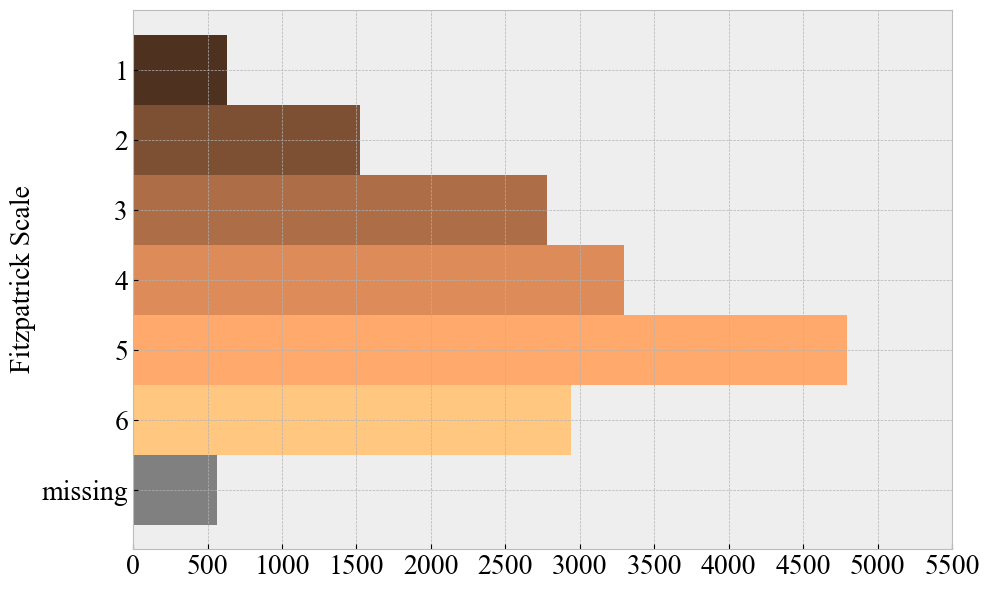

In [4]:
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import numpy as np

import logging

SKIN_COLORS = plt.cm.copper_r(np.linspace(0, 0.75, 6))
SKIN_COLORS = np.concatenate(([ np.array([0.5, 0.5, 0.5, 1])] , SKIN_COLORS))
fontsize=16

classes = ['missing', '6', '5', '4', '3', '2', '1']
skin_df_class_counts = skin_df.groupby(['fitzpatrick']).size().reset_index(name='count')

x = np.arange(len(classes))  # the label locations
width = 1  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))



ax.barh(
    x * width, 
    skin_df_class_counts['count'],
    width,
    label=classes,
    color=SKIN_COLORS
)

# ax.set_title('Distribution of disease type by skin tone', fontsize=fontsize + 16)
ax.set_xlim(0, 3750)
ax.set_xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])
for t in ax.get_xticklabels():    #get_xticklabels will get you the label objects, same for y
    t.set_fontsize(fontsize + 4)
ax.set_yticks(x, classes, fontsize=fontsize + 4)
#ax.set_yticklabels(['6', '5', '4', '3', '2', '1', 'missing'], fontsize=fontsize + 12)
ax.set_ylabel('Fitzpatrick Scale', fontsize=fontsize + 4)

# for bar in bars:
    # ax.bar_label(bar, padding=4, fontsize=fontsize+6)
    
fig.tight_layout()
plt.savefig(fig_dir / 'fitz-subgroup-class-dist.pdf')
plt.show()

## Prediction results 

Train ResNet18 model on fitzpatrick dataset for skin lesion classification (114 classes). The output should be a CSV that includes rows that represent log probabilities or logies for each of the 114 classes. In our scenario, we wrote a [custom script](https://github.com/stujaffe/conformal-predictors-vgg-model/blob/main/final_project/run_model.py) to obtain these log probabilities, and output them to a CSV.

### Load the log probability outputs from ResNet18 final layer

In [5]:
from sklearn.model_selection import train_test_split

#best run so far, with test_size = 0.4
df = pd.read_csv("results_50_random_holdout_val_resnet_newlayer_lowdropout_alllogits.csv")
df.loc[df['fitzpatrick_scale'] == -1, 'fitzpatrick_scale'] = 0

valid_df, test_df = train_test_split(df, test_size=0.4, stratify=df['fitzpatrick_scale'])


### Prediction Accuracy

First, calculate the accuracy of our ResNet18 model predictions. This comparison is done by looking at the amount of time the true label matches the prediction. We'll look at both accuracy of a correct prediction, and also the accuracy of getting the true label in the top 3 predictions. This is useful to us because we're going to be dealing with prediction sets later. Also, the training/validation accuracy reported from ResNet was fairly low (15-30% range), so looking at top 3 results can help us better guage minor accuracy improvements as we tweak hyperparameters.

In [6]:
accuracy = []
correct = 0

for i, row in test_df.iterrows():
    label = row.label

    #pred = np.argmax([c for c in row[1:]])
    pred = row.d1
    if label == pred: correct += 1
accuracy.append(correct / len(test_df))

top3_accuracy = []
top3_correct = 0

for i, row in test_df.iterrows():
    label = row.label

    #pred = np.argmax([c for c in row[1:]])
    pred = row.d1
    if label == row.d1 or label == row.d2 or label == row.d3: 
        top3_correct += 1
top3_accuracy.append(top3_correct / len(test_df))

In [7]:
print(f'average accuracy: {np.mean(accuracy):.2f} +/- {np.std(accuracy):.2f}')
print(f'average accuracy in top 3: {np.mean(top3_accuracy):.2f} +/- {np.std(top3_accuracy):.2f}')

average accuracy: 0.18 +/- 0.00
average accuracy in top 3: 0.34 +/- 0.00


In [8]:
# Percent of entries with top guesses greater than 0.2
print(f'Percent of entries with top guesses greater than 0.2: {len(test_df[test_df["p1"] > 0.2]) / len(test_df)}')

Percent of entries with top guesses greater than 0.2: 0.3203266787658802


In [9]:
# number of  classses
C = 114

def get_logits(row):
    return np.array([row[f'logit_class_{c}'] for c in range(C)]).tolist()
    # all_pred = [row[f'pred_{c}'] for c in range(C)]
    # return np.array(all_pred).mean(1).tolist()

valid_df['logits'] = valid_df.apply(lambda row: get_logits(row), axis=1)
test_df['logits'] = test_df.apply(lambda row: get_logits(row), axis=1)

### Apply platt scaling

In [10]:
# We hit an error here, I believe because we reduced our class size down to 3 (aka top 3)
# When we go to index into logits, that index doesn't exist.

# learn temperature weight using validation set
T = platt.get_platt_scaling(valid_df.label.values, [x for x in valid_df.logits.values])
valid_logits = torch.tensor([x for x in valid_df.logits.values]) 
valid_df['scores'] = torch.softmax(valid_logits / T, axis=1).tolist()

# apply on test set
test_logits = torch.tensor([x for x in test_df.logits.values]) 
test_df['scores'] = torch.softmax(test_logits / T, axis=1).tolist()


### Subgroups

These map to the Fitzpatrick Scale, and 0 represents unlabeled data.

In [11]:
#A = list(reversed(range(len(df.fitzpatrick_scale.unique()))))
A = [6, 5, 4, 3, 2, 1, 0]
A

[6, 5, 4, 3, 2, 1, 0]

### Miscoverage levels $\alpha$

<!-- $$1 - \alpha \leq P(\hat{Y}_{n+1} \in \mathcal{C}(X_{n+1})) \leq 1 - \alpha + \frac{1}{n + 1}$$ -->

In [12]:
ALPHAS = [round(x, 2) for x in np.arange(0.05, 0.55, 0.05)]
print(ALPHAS)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


### Conformal metrics

1. __Marginal coverage__ -- probability that the true class is contained within prediction set 
2. __Marginal cardinality__ - expected prediction set size
3. __Subgroup coverage__  - marginal coverage per subgroup 
4. __Subgroup cardinality__  - marginal cardinality per subgroup 

In [13]:
#
# Returns the percentage of True labels correctly showing up in prediction set.
#
def get_coverage(labels: list, prediction_sets: list) -> float:
    k = len(labels)
    assert k
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / k

#
# Returns the average length of prediction set given a list of sets
#
def get_cardinality(prediction_sets: list) -> float:
    k = len(prediction_sets)
    assert k
    return sum([len(x) for x in prediction_sets]) / k

#
# Returns the coverage (% of True label showing in pred set) for each subgroup.
#
def get_subgroup_coverage(df, pred_col, label_col='label', subgroup_col='fitzpatrick_scale', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_coverage(
            sub_df[label_col].values.tolist(),
            sub_df[pred_col].values.tolist(),
        )
    return res

#
# Returns the cardinality (average set size) for each subgroup.
#
def get_subgroup_cardinality(df, pred_col, subgroup_col='fitzpatrick_scale', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_cardinality(sub_df[pred_col].values.tolist())
    return res

### Helper functions

In [14]:
def aggregate_coverage(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    coverage_by_alpha = collections.defaultdict(list)
    for alpha in alphas:
        labels = [x for x in dfs.label.values]
        prediction_sets = [x for x in dfs[f'{prefix}_{alpha}'].values]
        coverage_by_alpha[alpha].append(get_coverage(labels, prediction_sets))
    
    coverage_by_alpha = dict(coverage_by_alpha)
    alpha, coverage = zip(*coverage_by_alpha.items())
    coverage = np.array(coverage)
    coverage_mean = coverage.mean(1)
    coverage_std = coverage.std(1)
    return alpha, coverage_mean, coverage_std
    
def aggregate_cardinality(dfs, prefix, alphas=ALPHAS):
    cardinality_by_alpha = collections.defaultdict(list)

    for alpha in ALPHAS:
        labels = [x for x in dfs.label.values]
        prediction_sets = [x for x in dfs[f'{prefix}_{alpha}'].values]
        cardinality_by_alpha[alpha].append(get_cardinality(prediction_sets))

    cardinality_by_alpha = dict(cardinality_by_alpha)
    alpha, cardinality = zip(*cardinality_by_alpha.items())
    cardinality = np.array(cardinality)
    cardinality_mean = cardinality.mean(1)
    cardinality_std = cardinality.std(1)
    return alpha, cardinality_mean, cardinality_std

In [15]:
# Helper functions for subgroup
def aggregate_coverage_subgroup(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    subgroup_coverage_by_alpha = collections.defaultdict(dict)
    for alpha in alphas:
        for sub, cov in get_subgroup_coverage(dfs, f'{prefix}_{alpha}').items():
            if sub in subgroup_coverage_by_alpha[alpha]:
                subgroup_coverage_by_alpha[alpha][sub] += [cov]
            else:
                subgroup_coverage_by_alpha[alpha][sub] = [cov]
    
    alpha, subgroup_cov = zip(*subgroup_coverage_by_alpha.items())

    coverage_mean = collections.defaultdict(list)
    coverage_std = collections.defaultdict(list)

    for res in subgroup_cov:
        for group, cov in res.items():
            cov = np.array(cov)
            coverage_mean[group].append(cov.mean())
            coverage_std[group].append(cov.std())

    coverage_mean = dict(coverage_mean)
    coverage_std = dict(coverage_std)
    
    return alpha, coverage_mean, coverage_std

    
def aggregate_cardinality_subgroup(dfs, prefix, alphas=ALPHAS):
    subgroup_cardinality_by_alpha = collections.defaultdict(dict)

    for alpha in ALPHAS:
        for sub, card in get_subgroup_cardinality(dfs, f'{prefix}_{alpha}').items():
            if sub in subgroup_cardinality_by_alpha[alpha]:
                subgroup_cardinality_by_alpha[alpha][sub] += [card]
            else:
                subgroup_cardinality_by_alpha[alpha][sub] = [card]

    subgroup_cardinality_by_alpha = dict(subgroup_cardinality_by_alpha)
    alpha, cardinality = zip(*subgroup_cardinality_by_alpha.items())
    
    cardinality_mean = collections.defaultdict(list)
    cardinality_std = collections.defaultdict(list)

    for res in cardinality:
        for group, card in res.items():
            card = np.array(card)
            cardinality_mean[group].append(card.mean())
            cardinality_std[group].append(card.std())

    cardinality_mean = dict(cardinality_mean)
    cardinality_std = dict(cardinality_std)
    
    return alpha, cardinality_mean, cardinality_std

### Naive prediction sets

* Platt scaling on logits
* Form set by adding elements from sorted softmax scores until cumulative sum exceeds $1 - \alpha$

In [16]:
naive_qhat = {}

# valid_df
scores = [x for x in valid_df.scores.values]
labels = [x for x in valid_df.label.values]
s = torch.tensor([1 - s[l] for s, l in zip(scores, labels)])
n = len(valid_df)
for alpha in ALPHAS:
    p = np.ceil((n + 1) * (1 - alpha)) / n
    naive_qhat[alpha] = torch.quantile(s, p).item()

# test_df
scores = np.array([x for x in test_df.scores.values])
for alpha in ALPHAS:
    test_df[f'naive_{alpha}'] = [np.nonzero(s > (1 - naive_qhat[alpha]))[0] for s in scores]

In [17]:
columns = [f'naive_{alpha}' for alpha in ALPHAS]
test_df[columns].head()


,naive_0.05,naive_0.1,naive_0.15,naive_0.2,naive_0.25,naive_0.3,naive_0.35,naive_0.4,naive_0.45,naive_0.5
3179,"[0, 1, 5, 6, 7, 8, 11, 15, 16, 17, 20, 22, 23,...","[0, 1, 5, 7, 8, 11, 16, 20, 22, 32, 34, 41, 43...","[1, 5, 7, 8, 11, 16, 20, 22, 32, 41, 45, 46, 4...","[1, 5, 7, 8, 11, 20, 32, 45, 46, 48, 51, 57, 5...","[1, 5, 7, 11, 20, 32, 45, 48, 51, 57, 58, 60, ...","[1, 5, 7, 11, 20, 32, 45, 48, 57, 58, 70, 73, ...","[5, 7, 11, 32, 45, 48, 57, 58, 70, 73, 76, 86,...","[7, 32, 45, 48, 58, 70, 73, 76, 92, 95]","[7, 45, 58, 70, 73, 76, 92, 95]","[7, 45, 58, 70, 73, 76, 92, 95]"
1588,"[0, 3, 5, 6, 12, 15, 17, 18, 19, 20, 22, 24, 2...","[0, 3, 5, 6, 12, 15, 17, 18, 19, 20, 22, 24, 2...","[0, 6, 12, 15, 18, 19, 20, 22, 26, 29, 31, 34,...","[6, 15, 18, 19, 20, 26, 29, 31, 34, 39, 44, 47...","[6, 15, 18, 19, 26, 29, 31, 34, 39, 44, 47, 48...","[6, 15, 18, 26, 29, 31, 34, 44, 47, 48, 50, 63...","[6, 15, 18, 29, 31, 34, 44, 47, 48, 50, 63, 65...","[6, 15, 18, 29, 34, 44, 47, 50, 63, 65, 80, 86...","[15, 29, 44, 47, 50, 63, 65, 80, 86, 99]","[15, 29, 47, 50, 63, 80, 86, 99]"
8016,"[0, 1, 5, 6, 7, 8, 10, 11, 14, 16, 17, 20, 23,...","[0, 5, 7, 8, 10, 14, 20, 37, 41, 43, 45, 48, 5...","[0, 5, 7, 8, 10, 14, 20, 37, 41, 43, 45, 48, 5...","[7, 8, 10, 14, 20, 37, 41, 43, 45, 51, 57, 58,...","[7, 8, 10, 20, 37, 41, 43, 45, 57, 58, 61, 62,...","[7, 8, 10, 41, 43, 45, 57, 58, 61, 62, 70, 73,...","[7, 8, 41, 43, 45, 57, 58, 61, 62, 70, 73, 76,...","[7, 8, 41, 43, 57, 58, 61, 62, 70, 73, 76, 77,...","[7, 8, 41, 57, 58, 61, 62, 70, 73, 76, 77, 94,...","[7, 41, 57, 58, 61, 70, 76, 77, 95, 104]"
2990,"[0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 17, 19, ...","[0, 1, 2, 3, 4, 6, 12, 13, 15, 17, 19, 20, 21,...","[1, 2, 4, 6, 13, 15, 17, 19, 20, 21, 22, 23, 2...","[1, 2, 4, 6, 13, 17, 19, 20, 21, 22, 23, 39, 4...","[1, 2, 4, 6, 13, 17, 19, 20, 22, 23, 40, 51, 5...","[1, 2, 4, 6, 13, 17, 19, 20, 22, 23, 40, 51, 5...","[1, 4, 17, 20, 22, 23, 51, 52, 74, 75, 76, 84,...","[1, 4, 17, 20, 22, 23, 51, 52, 74, 75, 84, 90,...","[4, 17, 23, 52, 74, 84, 90, 93, 95, 105]","[17, 74, 90, 105]"
299,"[1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, ...","[1, 5, 8, 9, 11, 12, 16, 18, 19, 22, 26, 28, 3...","[1, 5, 8, 9, 11, 12, 16, 26, 28, 31, 32, 34, 3...","[1, 8, 9, 12, 16, 26, 28, 31, 32, 34, 35, 41, ...","[8, 9, 16, 28, 31, 32, 35, 41, 43, 57, 76, 77,...","[8, 16, 31, 32, 41, 43, 57, 76, 77, 82, 86, 87...","[8, 16, 41, 43, 57, 76, 77, 82, 86, 87, 91, 97...","[8, 16, 41, 43, 57, 76, 77, 82, 86, 97, 106]","[8, 16, 41, 43, 57, 76, 77, 97, 106]","[16, 41, 57, 76, 77, 97]"


In [18]:
alpha, naive_coverage_mean, naive_coverage_std = aggregate_coverage(test_df, prefix='naive')
alpha, naive_cardinality_mean, naive_cardinality_std = aggregate_cardinality(test_df, prefix='naive')

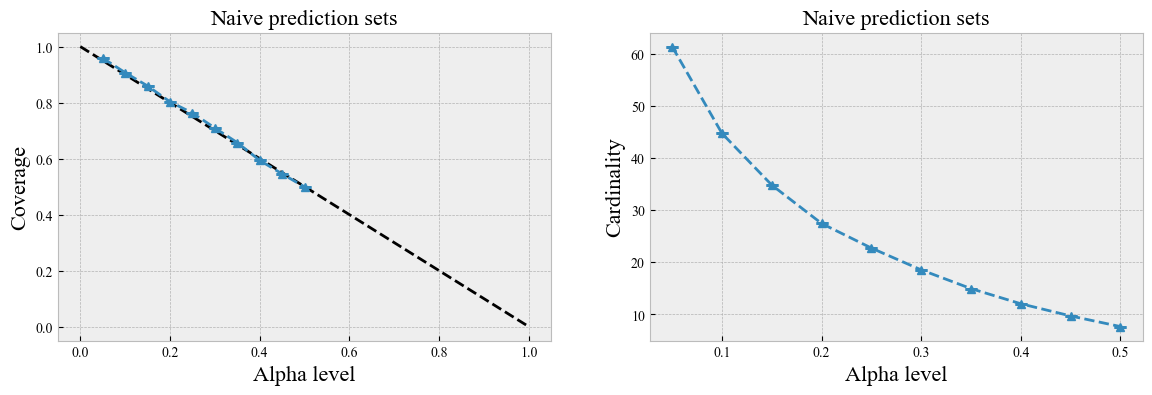

In [19]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].set_title('Naive prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('Naive prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Adaptive prediction set (APS)

* Calibration set for correct marginal coverage

In [20]:
importlib.reload(conformal)

<module 'src.conformal' from 'C:\\Grad\\Classes\\CS598\\Paper\\conformal-predictors-in-medical-imaging\\src\\conformal.py'>

In [21]:
# calibrate 
aps_qhat = collections.defaultdict(dict)

# scores & labels have the same length
# scores is a 2D array. The first dimension represents the images
# and the second dimension represents the score on each of the 114
# total classes. They add up to 1 (i.e. len(scores[0]))
scores = [x for x in valid_df.scores.values]
labels = [x for x in valid_df.label.values]
#labels = torch.arange(114).repeat(len(scores), 1)

#print(labels)

assert math.isclose(sum(scores[0]), 1, rel_tol=0.001, abs_tol=0.001)

for alpha in ALPHAS:
    qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
    aps_qhat[alpha] = qhat.item()
        
aps_qhat = dict(aps_qhat)

In [22]:
print(aps_qhat[0.1])

0.8711376190185547


In [23]:
# inference
scores = [x for x in test_df.scores.values]
for alpha in ALPHAS:
    qhat = aps_qhat[alpha]
    test_df[f'aps_{alpha}'] = conformal.conformal_inference(scores, qhat)

In [24]:
columns = [f'aps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,aps_0.05,aps_0.1,aps_0.15,aps_0.2,aps_0.25,aps_0.3,aps_0.35,aps_0.4,aps_0.45,aps_0.5
3179,"[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57,...","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48, 5, 57]","[45, 7, 95, 73, 76, 70, 58, 92, 32, 48]","[45, 7, 95, 73, 76, 70, 58, 92]"
1588,"[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 3...","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65, 18, 34]","[29, 47, 63, 50, 80, 99, 86, 15, 44, 65]","[29, 47, 63, 50, 80, 99, 86, 15]"
8016,"[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73...","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41, 8, 73]","[104, 70, 57, 77, 58, 61, 95, 7, 76, 41]","[104, 70, 57, 77, 58, 61, 95, 7, 76]"
2990,"[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1...","[74, 90, 105, 17, 84, 93, 95, 52, 4, 23, 22, 1..."
299,"[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8...","[16, 77, 57, 97, 41, 76, 8, 43, 106, 82, 86, 8..."


In [25]:
alpha, aps_coverage_mean, aps_coverage_std = aggregate_coverage(test_df, prefix='aps')
alpha, aps_cardinality_mean, aps_cardinality_std = aggregate_cardinality(test_df, prefix='aps')

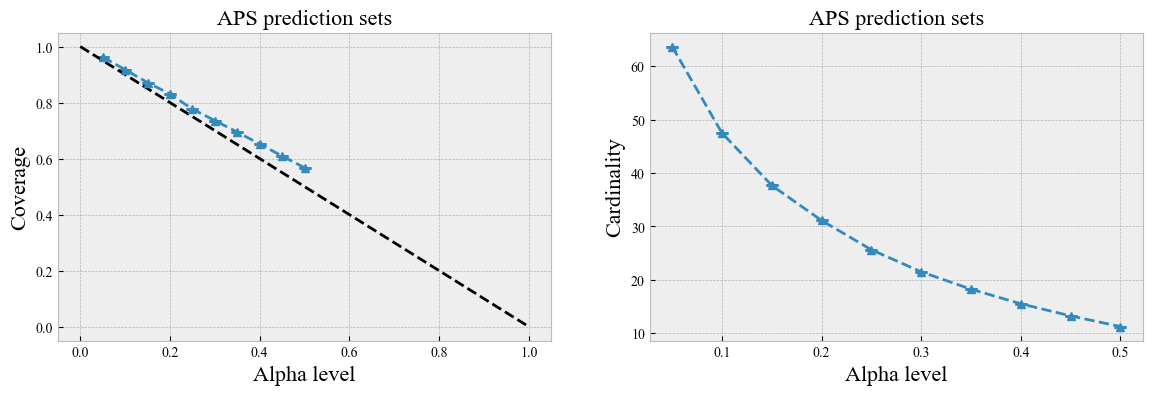

In [26]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('APS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('APS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group APS (GAPS)

Conformal calibration for each subgroup 

In [27]:
# calibrate 
gaps_qhat = collections.defaultdict(dict)

#for k, df in valid_dfs.items():

alpha_qhat = collections.defaultdict(dict)
for alpha in ALPHAS: # [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    group_qhat = collections.defaultdict(dict)
    for a in A: # [6, 5, 4, 3, 2, 1]
        group_df = valid_df[valid_df.fitzpatrick_scale == a]
        
        scores = [x for x in group_df.scores.values]
        
        labels = [x for x in group_df.label.values]
        qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
        gaps_qhat[alpha] = qhat.item()

        group_qhat[a] = qhat

    alpha_qhat[alpha] = dict(group_qhat)

gaps_qhat = dict(alpha_qhat)
#end for loop

In [28]:
# inference

#for k, df in test_dfs.items():
temp = []
scores = np.array([x for x in test_df.scores.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for a in A:
    group_df = test_df[test_df.fitzpatrick_scale == a].copy()

    # APS
    scores = [x for x in group_df.scores.values]
    for alpha in ALPHAS:
        qhat = gaps_qhat[alpha][a]
        group_df[f'gaps_{alpha}'] = conformal.conformal_inference(scores, qhat)

    temp.append(group_df)
test_df = pd.concat(temp)

In [29]:
# columns = [f'gaps_{alpha}' for alpha in ALPHAS]
columns = [f'gaps_{alpha}' for alpha in ALPHAS]
print(len(test_df[columns]))
test_df[columns].sort_index().head()

3306


,gaps_0.05,gaps_0.1,gaps_0.15,gaps_0.2,gaps_0.25,gaps_0.3,gaps_0.35,gaps_0.4,gaps_0.45,gaps_0.5
0,"[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10...","[14, 23, 39, 24, 93, 110, 40, 21, 111, 102, 10..."
1,"[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57...","[44, 18, 53, 109, 101, 78, 65, 29, 34, 102, 57..."
2,"[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19, 5...","[12, 93, 29, 64, 40, 21, 20, 34, 63, 22, 19]","[12, 93, 29, 64, 40, 21, 20, 34, 63]"
3,"[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2...","[52, 65, 28, 21, 87, 15, 19, 34, 83, 40, 86, 2..."
4,"[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9...","[74, 36, 52, 101, 87, 84, 90, 38, 51, 26, 2, 9..."


In [30]:
alpha, gaps_coverage_mean, gaps_coverage_std = aggregate_coverage(test_df, prefix='gaps')
alpha, gaps_cardinality_mean, gaps_cardinality_std = aggregate_cardinality(test_df, prefix='gaps')

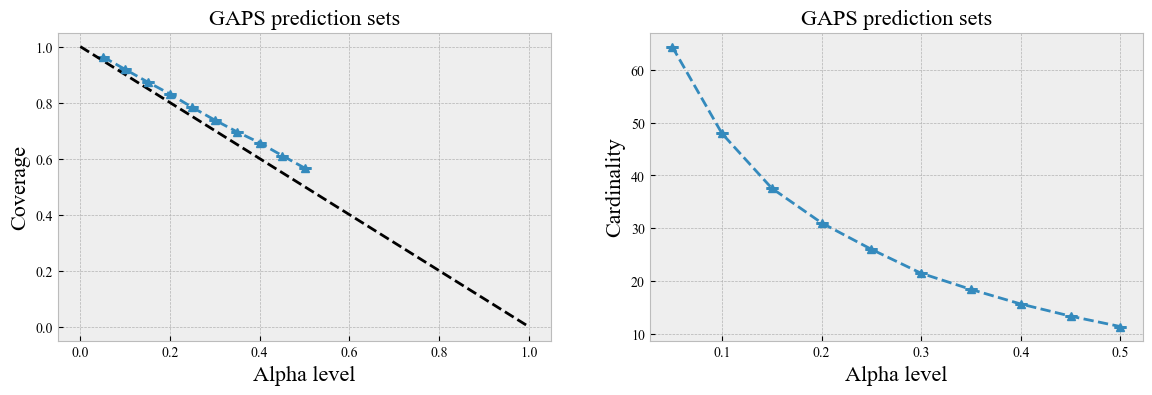

In [31]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, gaps_coverage_mean, yerr=gaps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('GAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, gaps_cardinality_mean, yerr=gaps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('GAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Regularized adaptive prediction set (RAPS)

* Calibration set for correct marginal coverage
* Parameterized regulaization penality $\lambda$ and $K$

In [32]:
K_REG = 0
LAMBDA = 1e-4

penalty = np.zeros((1, C))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

In [33]:
# calibrate 
raps_qhat = collections.defaultdict(dict)
#for k, df in valid_dfs.items():
scores = np.array([x for x in valid_df.scores.values])
labels = np.array([x for x in valid_df.label.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for alpha in ALPHAS:
    qhat = conformal.raps_calibrate(
        scores, labels, index, ordered, cumsum,
        penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
    )
    raps_qhat[alpha] = qhat
        
raps_qhat = dict(raps_qhat)

In [34]:
print(raps_qhat[0.05])

0.9427231312058195


In [35]:
# inference
#for k, df in test_dfs.items():
scores = np.array([x for x in test_df.scores.values])
index, ordered, cumsum = conformal.sort_sum(scores)
for alpha in ALPHAS:
    qhat = raps_qhat[alpha]
    test_df[f'raps_{alpha}'] = conformal.raps_predict(
        C, qhat, index, ordered, cumsum, 
        penalty, randomized=RAND, allow_zero_sets=ZERO,
    )

In [36]:
columns = [f'raps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,raps_0.05,raps_0.1,raps_0.15,raps_0.2,raps_0.25,raps_0.3,raps_0.35,raps_0.4,raps_0.45,raps_0.5
2868,"[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62]","[71, 0]","[71, 0]",[71],[71],[71],[71],[71]
2509,"[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92..."
6809,"[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8]","[108, 54, 33, 11, 107, 98, 30, 100, 61]","[108, 54, 33, 11, 107, 98]","[108, 54, 33, 11, 107]","[108, 54, 33, 11]"
6360,"[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51]","[80, 15, 20, 60, 92, 113, 42, 86, 22]"
3312,"[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5..."


In [37]:
alpha, raps_coverage_mean, raps_coverage_std = aggregate_coverage(test_df, prefix='raps')
alpha, raps_cardinality_mean, raps_cardinality_std = aggregate_cardinality(test_df, prefix='raps')

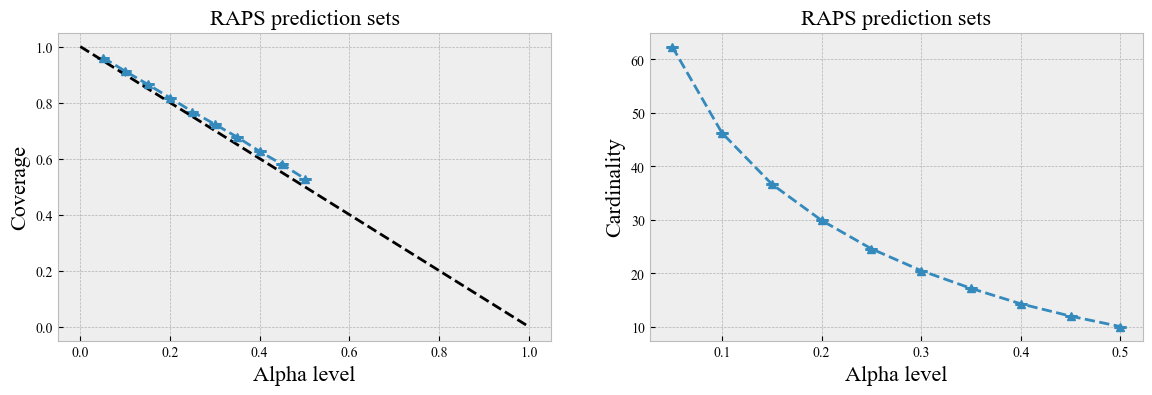

In [38]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('RAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('RAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group RAPS (GRAPS)

In [39]:
# calibrate 
graps_qhat = collections.defaultdict(dict)

#for k, df in valid_dfs.items():
alpha_qhat = collections.defaultdict(dict)
for alpha in ALPHAS:
    group_qhat = collections.defaultdict(dict)
    for a in A:
        group_df = valid_df[valid_df.fitzpatrick_scale == a]

        scores = np.array([x for x in group_df.scores.values])
        labels = np.array([x for x in group_df.label.values])
        index, ordered, cumsum = conformal.sort_sum(scores)
        qhat = conformal.raps_calibrate(
            scores, labels, index, ordered, cumsum,
            penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
        )

        group_qhat[a] = qhat

    alpha_qhat[alpha] = dict(group_qhat)

graps_qhat = dict(alpha_qhat)

In [40]:
# inference

#for k, df in test_dfs.items():
temp = []
for a in A:
    group_df = test_df[test_df.fitzpatrick_scale == a].copy()
    # RAPS
    scores = np.array([x for x in group_df.scores.values])
    for alpha in ALPHAS:
        qhat = graps_qhat[alpha][a]
        index, ordered, cumsum = conformal.sort_sum(scores)
        group_df[f'graps_{alpha}'] = conformal.raps_predict(
            C, qhat.item(), index, ordered, cumsum, 
            penalty, randomized=RAND, allow_zero_sets=ZERO,
        )

    temp.append(group_df)
    print(group_df.columns.values)
test_df = pd.concat(temp)

print(test_df.columns.values)

['hasher' 'label' 'fitzpatrick_scale' 'prediction_probability'
 'prediction' 'd1' 'd2' 'd3' 'p1' 'p2' 'p3' 'logit_class_0'
 'logit_class_1' 'logit_class_2' 'logit_class_3' 'logit_class_4'
 'logit_class_5' 'logit_class_6' 'logit_class_7' 'logit_class_8'
 'logit_class_9' 'logit_class_10' 'logit_class_11' 'logit_class_12'
 'logit_class_13' 'logit_class_14' 'logit_class_15' 'logit_class_16'
 'logit_class_17' 'logit_class_18' 'logit_class_19' 'logit_class_20'
 'logit_class_21' 'logit_class_22' 'logit_class_23' 'logit_class_24'
 'logit_class_25' 'logit_class_26' 'logit_class_27' 'logit_class_28'
 'logit_class_29' 'logit_class_30' 'logit_class_31' 'logit_class_32'
 'logit_class_33' 'logit_class_34' 'logit_class_35' 'logit_class_36'
 'logit_class_37' 'logit_class_38' 'logit_class_39' 'logit_class_40'
 'logit_class_41' 'logit_class_42' 'logit_class_43' 'logit_class_44'
 'logit_class_45' 'logit_class_46' 'logit_class_47' 'logit_class_48'
 'logit_class_49' 'logit_class_50' 'logit_class_51' 'logit

['hasher' 'label' 'fitzpatrick_scale' 'prediction_probability'
 'prediction' 'd1' 'd2' 'd3' 'p1' 'p2' 'p3' 'logit_class_0'
 'logit_class_1' 'logit_class_2' 'logit_class_3' 'logit_class_4'
 'logit_class_5' 'logit_class_6' 'logit_class_7' 'logit_class_8'
 'logit_class_9' 'logit_class_10' 'logit_class_11' 'logit_class_12'
 'logit_class_13' 'logit_class_14' 'logit_class_15' 'logit_class_16'
 'logit_class_17' 'logit_class_18' 'logit_class_19' 'logit_class_20'
 'logit_class_21' 'logit_class_22' 'logit_class_23' 'logit_class_24'
 'logit_class_25' 'logit_class_26' 'logit_class_27' 'logit_class_28'
 'logit_class_29' 'logit_class_30' 'logit_class_31' 'logit_class_32'
 'logit_class_33' 'logit_class_34' 'logit_class_35' 'logit_class_36'
 'logit_class_37' 'logit_class_38' 'logit_class_39' 'logit_class_40'
 'logit_class_41' 'logit_class_42' 'logit_class_43' 'logit_class_44'
 'logit_class_45' 'logit_class_46' 'logit_class_47' 'logit_class_48'
 'logit_class_49' 'logit_class_50' 'logit_class_51' 'logit

In [41]:
columns = [f'graps_{alpha}' for alpha in ALPHAS]
test_df[columns].head()

,graps_0.05,graps_0.1,graps_0.15,graps_0.2,graps_0.25,graps_0.3,graps_0.35,graps_0.4,graps_0.45,graps_0.5
2868,"[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47, 110, 60, 23, 3...","[71, 0, 10, 58, 95, 62, 79, 47]","[71, 0, 10, 58]","[71, 0]",[71],[71],[71],[71],[71]
2509,"[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92...","[89, 12, 43, 83, 23, 21, 4, 64, 20, 42, 13, 92..."
6809,"[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8,...","[108, 54, 33, 11, 107, 98, 30, 100, 61, 25, 8]","[108, 54, 33, 11, 107, 98, 30, 100, 61]","[108, 54, 33, 11, 107, 98, 30]","[108, 54, 33, 11, 107]"
6360,"[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19, 51, ...","[80, 15, 20, 60, 92, 113, 42, 86, 22, 19]"
3312,"[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5...","[113, 92, 47, 15, 58, 70, 33, 49, 62, 0, 48, 5..."


In [42]:
alpha, graps_coverage_mean, graps_coverage_std = aggregate_coverage(test_df, prefix='graps')
alpha, graps_cardinality_mean, graps_cardinality_std = aggregate_cardinality(test_df, prefix='graps')

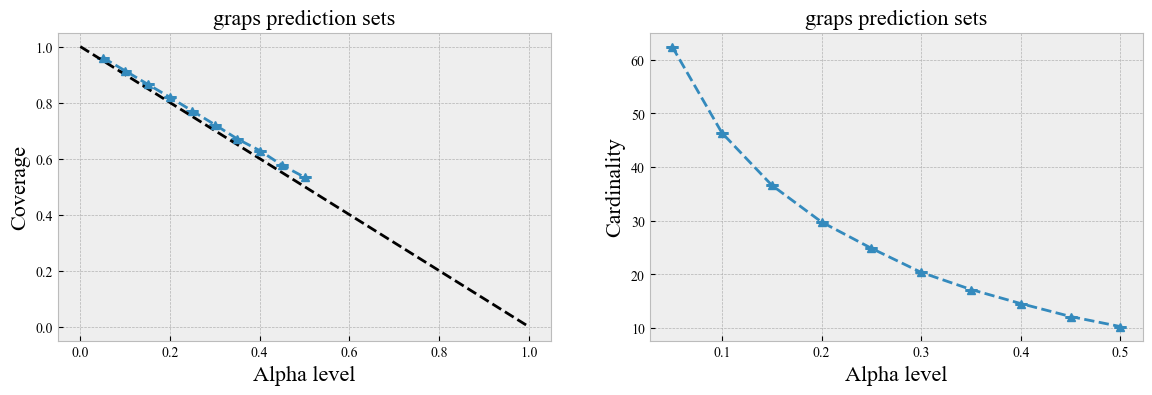

In [43]:

fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, graps_coverage_mean, yerr=graps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('graps prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, graps_cardinality_mean, yerr=graps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('graps prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Overall comparison

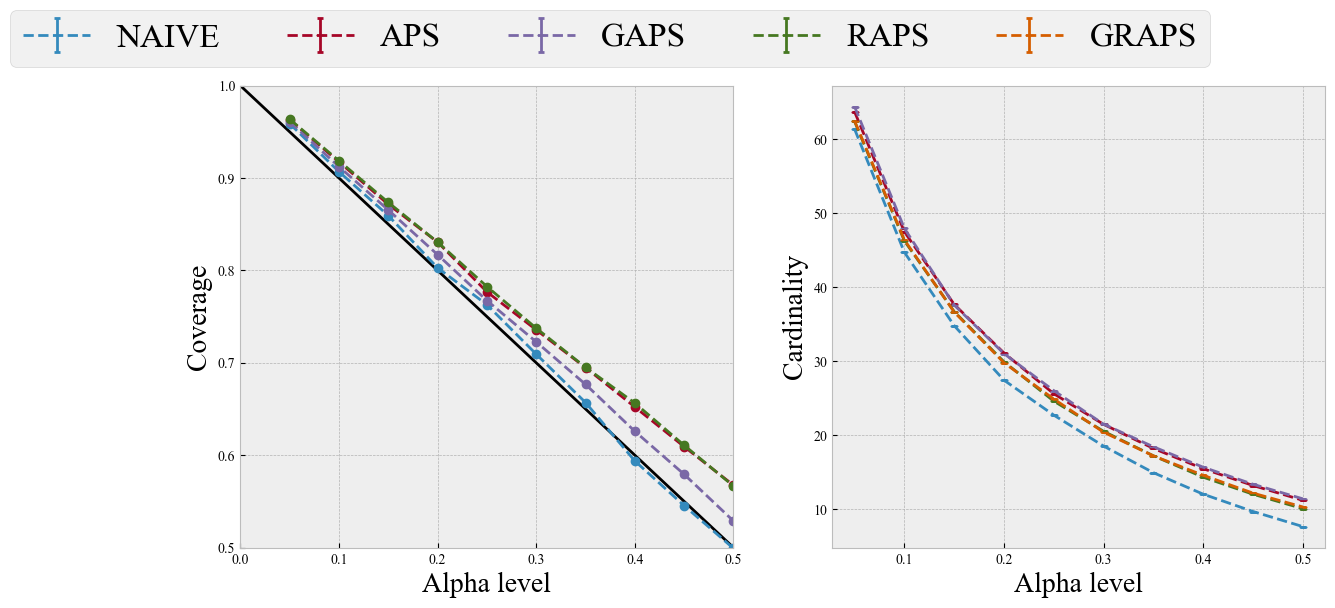

In [44]:
capsize = 2
fontsize=20
capthick=2
lw = 2
marker='o'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
ax[0].set_xlim(0, 0.5)
ax[0].set_ylim(0.5, 1)
ax[0].plot([1, 0], [0, 1], c='k', label='Ideal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[0].errorbar(
    alpha, gaps_coverage_mean , yerr=gaps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[1].errorbar(
    alpha, gaps_cardinality_mean , yerr=gaps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GAPS',
)
ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[1].errorbar(
    alpha, graps_cardinality_mean , yerr=graps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GRAPS',
)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.legend(fontsize=fontsize + 4, bbox_to_anchor=(0.8, 1.2), ncol=5)
plt.savefig(fig_dir / 'fitz-compare.png')
plt.show()

### Subgroup comparison

In [45]:
alpha, naive_subgroup_coverage_mean, naive_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='naive'
)
alpha, naive_subgroup_cardinality_mean, naive_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='naive'
)
alpha, aps_subgroup_coverage_mean, aps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='aps'
)
alpha, aps_subgroup_cardinality_mean, aps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='aps'
)
alpha, raps_subgroup_coverage_mean, raps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='raps'
)
alpha, raps_subgroup_cardinality_mean, raps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='raps'
)
alpha, gaps_subgroup_coverage_mean, gaps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='gaps'
)
alpha, gaps_subgroup_cardinality_mean, gaps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='gaps'
)
alpha, graps_subgroup_coverage_mean, graps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_df, prefix='graps'
)
alpha, graps_subgroup_cardinality_mean, graps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_df, prefix='graps'
)

2023-05-09 00:21:22,722 - maxp pruned
2023-05-09 00:21:22,722 - cmap pruned
2023-05-09 00:21:22,722 - post pruned
2023-05-09 00:21:22,722 - PCLT dropped
2023-05-09 00:21:22,737 - name pruned
2023-05-09 00:21:22,737 - 'created' timestamp seems very low; regarding as unix timestamp
2023-05-09 00:21:22,737 - 'modified' timestamp seems very low; regarding as unix timestamp
2023-05-09 00:21:22,750 - glyf pruned
2023-05-09 00:21:22,754 - Added gid0 to subset
2023-05-09 00:21:22,757 - Added first four glyphs to subset
2023-05-09 00:21:22,759 - Closing glyph list over 'glyf': 5 glyphs before
2023-05-09 00:21:22,759 - Glyph names: ['.notdef', '.null', 'alpha', 'e', 'nonmarkingreturn']
2023-05-09 00:21:22,759 - Glyph IDs:   [0, 1, 2, 3, 13]
2023-05-09 00:21:22,769 - Closed glyph list over 'glyf': 5 glyphs after
2023-05-09 00:21:22,772 - Glyph names: ['.notdef', '.null', 'alpha', 'e', 'nonmarkingreturn']
2023-05-09 00:21:22,774 - Glyph IDs:   [0, 1, 2, 3, 13]
2023-05-09 00:21:22,778 - Retaining 5

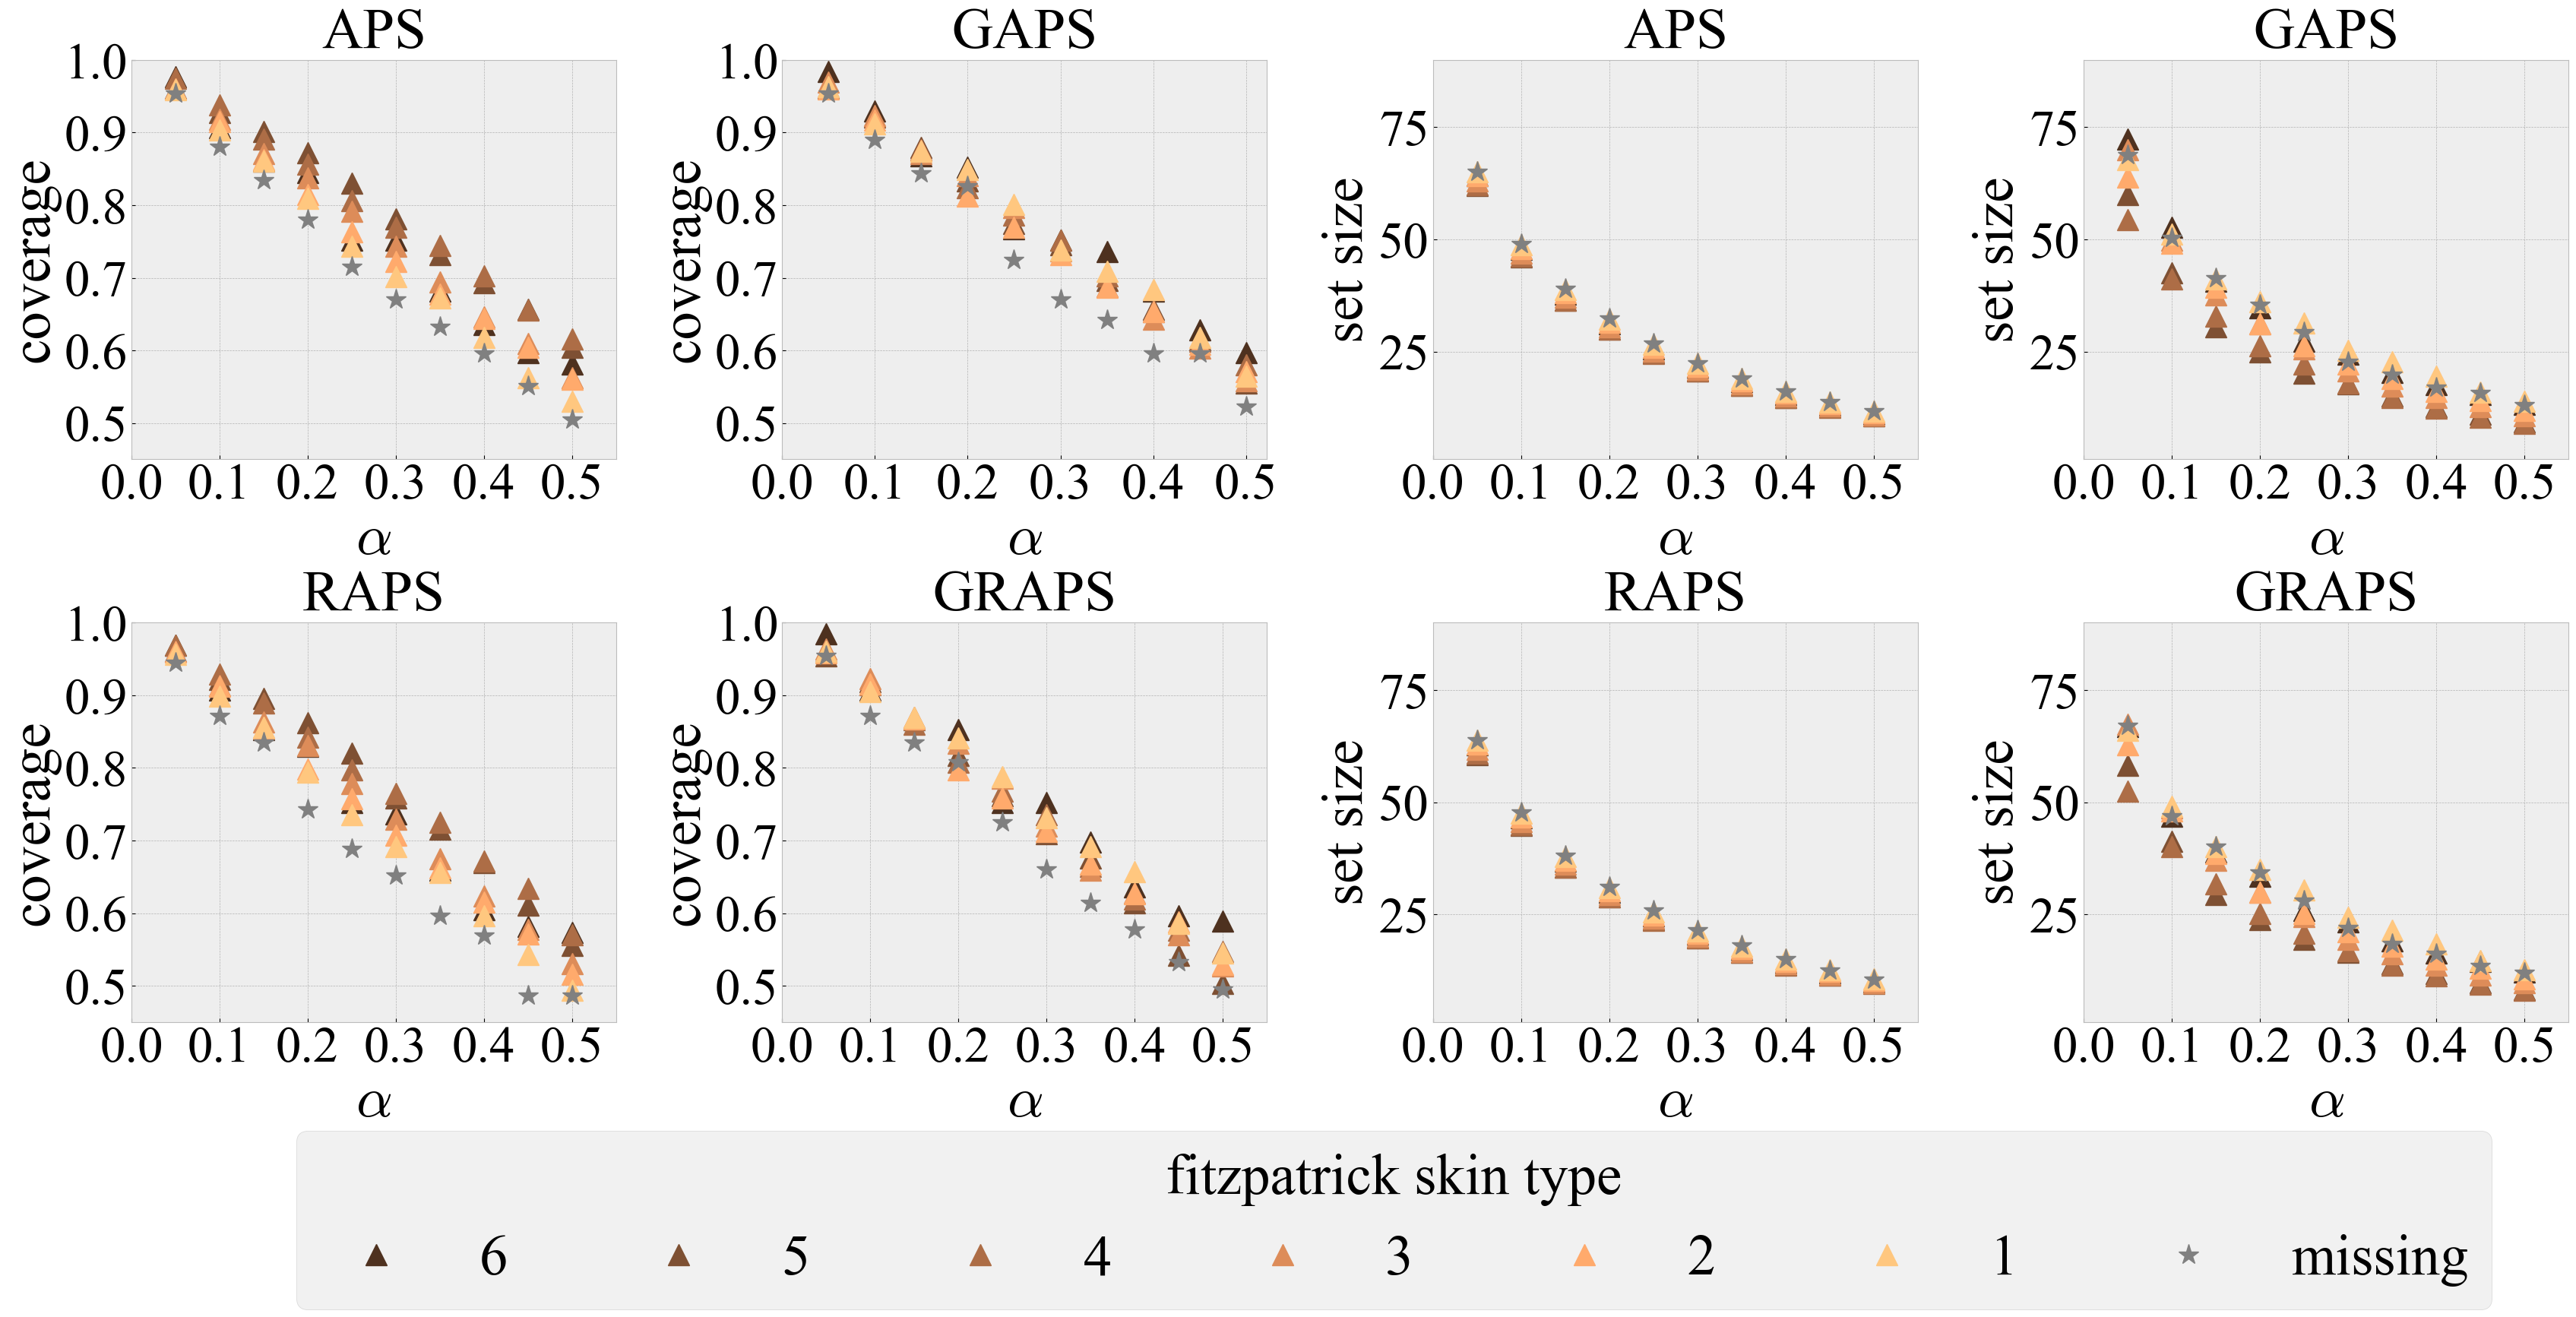

In [46]:
fontsize=54
labelsize=48
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(34, 18), sharex=False, sharey=False)
ls=''
lw=6
marker = '^'
ms = 20
alpha=1.0
xticks = np.arange(0.0, 0.51, 0.1)
yticks = np.arange(0.5, 1.01, 0.1)
xlim = (0, 0.55)
ylim = (0.45, 1.0)
SKIN_COLORS = plt.cm.copper_r(np.linspace(0, 0.75, 6))


# ax[0, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(aps_subgroup_coverage_mean.items()):
    ax[0, 0].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 0].set_title('APS', fontsize=fontsize )
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_ylim(*ylim)
ax[0, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 0].set_ylabel('coverage', fontsize=fontsize)
ax[0, 0].set_xticks(xticks)
ax[0, 0].set_yticks(yticks)
ax[0, 0].tick_params(axis='x', labelsize=labelsize)
ax[0, 0].tick_params(axis='y', labelsize=labelsize)

# ax[1, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(raps_subgroup_coverage_mean.items()):
    ax[1, 0].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 0].set_title('RAPS', fontsize=fontsize)
ax[1, 0].set_xlim(*xlim)
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 0].set_ylabel('coverage', fontsize=fontsize)
ax[1, 0].set_xticks(xticks)
ax[1, 0].set_yticks(yticks)
ax[1, 0].tick_params(axis='x', labelsize=labelsize)
ax[1, 0].tick_params(axis='y', labelsize=labelsize)

# ax[0, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(gaps_subgroup_coverage_mean.items()):
    ax[0, 1].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[0, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 1].set_title('GAPS', fontsize=fontsize)
ax[0, 1].set_ylim(*ylim)
ax[0, 1].set_ylim(*ylim)
ax[0, 1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 1].set_ylabel('coverage', fontsize=fontsize)
ax[0, 1].set_xticks(xticks)
ax[0, 1].set_yticks(yticks)
ax[0, 1].tick_params(axis='x', labelsize=labelsize )
ax[0, 1].tick_params(axis='y', labelsize=labelsize)

# ax[1, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(graps_subgroup_coverage_mean.items()):
    ax[1, 1].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 1].set_title('GRAPS', fontsize=fontsize)
ax[1, 1].set_xlim(*xlim)
ax[1, 1].set_ylim(*ylim)
ax[1, 1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 1].set_ylabel('coverage', fontsize=fontsize)
ax[1, 1].set_xticks(xticks)
ax[1, 1].set_yticks(yticks)
ax[1, 1].tick_params(axis='x', labelsize=labelsize )
ax[1, 1].tick_params(axis='y', labelsize=labelsize)

xticks = np.arange(0.0, 0.6, 0.1)
yticks = np.arange(0, 1.1, 0.1)
xlim = (0, 0.55)
ylim = (1, 90)

for i, (k, v) in enumerate(aps_subgroup_cardinality_mean.items()):
    ax[0, 2].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[0, 2].set_xlim(*xlim)
ax[0, 2].set_ylim(*ylim)
ax[0, 2].set_title('APS', fontsize=fontsize )
ax[0, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 2].set_ylabel('set size', fontsize=fontsize)
ax[0, 2].set_xticks(xticks)
ax[0, 2].tick_params(axis='x', labelsize=labelsize)
ax[0, 2].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(raps_subgroup_cardinality_mean.items()):
    ax[1, 2].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 2].set_xlim(*xlim)
ax[1, 2].set_ylim(*ylim)
ax[1, 2].set_title('RAPS', fontsize=fontsize )
ax[1, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 2].set_ylabel('set size', fontsize=fontsize)
ax[1, 2].set_xticks(xticks)
ax[1, 2].tick_params(axis='x', labelsize=labelsize)
ax[1, 2].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(gaps_subgroup_cardinality_mean.items()):
    ax[0, 3].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[0, 3].set_xlim(*xlim)
ax[0, 3].set_ylim(*ylim)
ax[0, 3].set_title('GAPS', fontsize=fontsize )
ax[0, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 3].set_ylabel('set size', fontsize=fontsize)
ax[0, 3].set_xticks(xticks)
ax[0, 3].tick_params(axis='x', labelsize=labelsize)
ax[0, 3].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(graps_subgroup_cardinality_mean.items()):
    ax[1, 3].plot(ALPHAS, v, label=f'{"missing" if k == 0 else k}', ls=ls, lw=lw, alpha=alpha, marker='*' if k == 0 else marker, ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 3].set_xlim(*xlim)
ax[1, 3].set_ylim(*ylim)
ax[1, 3].set_title('GRAPS', fontsize=fontsize )
ax[1, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 3].set_ylabel('set size', fontsize=fontsize)
ax[1, 3].set_xticks(xticks)
ax[1, 3].tick_params(axis='x', labelsize=labelsize)
ax[1, 3].tick_params(axis='y', labelsize=labelsize)

handles, labels = ax[0, 0].get_legend_handles_labels()


plt.tight_layout(h_pad=4, w_pad=4)
plt.subplots_adjust(bottom=0.25)
plt.legend(
    handles,
    labels,
    title='fitzpatrick skin type', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize,
    },
    fontsize=fontsize,
    bbox_to_anchor=(0.90, -0.20, 0.0, 0),
    ncol=7,
)

plt.savefig(fig_dir / 'fitz-subgroup-coverage.pdf', bbox_inches="tight")
plt.show()

### Measure subgroup coverage / cardinaltiy disparity

In [47]:
def get_diff(res):
    diff = []
    for a, b in itertools.combinations(list(range(len(res))), 2):
        if a == b: continue
        diff.append(abs(res[a] - res[b]))
    return diff

In [48]:
coverage_disparity = {}
print('COVERAGE'.center(20, '='))
for a in ALPHAS:
    naive_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'naive_{a}').items():
        naive_sub_cov[sub].append(cov)
    naive_sub_cov = dict(naive_sub_cov)

    aps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'aps_{a}').items():
        aps_sub_cov[sub].append(cov)
    aps_sub_cov = dict(aps_sub_cov)

    raps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'raps_{a}').items():
        raps_sub_cov[sub].append(cov)
    raps_sub_cov = dict(raps_sub_cov)

    gaps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'gaps_{a}').items():
        gaps_sub_cov[sub].append(cov)
    gaps_sub_cov = dict(gaps_sub_cov)
    
    graps_sub_cov = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, cov in get_subgroup_coverage(test_df, pred_col=f'graps_{a}').items():
        graps_sub_cov[sub].append(cov)
    graps_sub_cov = dict(graps_sub_cov)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_cov))
    print('aps\t', f(aps_sub_cov))
    print('raps\t', f(raps_sub_cov))
    print('gaps\t', f(gaps_sub_cov))
    print('graps\t', f(graps_sub_cov))

    coverage_disparity[a] = {
        'naive': f(naive_sub_cov),
        'aps': f(aps_sub_cov),
        'raps': f(raps_sub_cov),
        'gaps': f(gaps_sub_cov),
        'graps': f(graps_sub_cov),
    }

print('\n')
print('AVERAGE DIFFERENCES BETWEEN SUBGROUPS FOR AGGREGRATE & GROUP CONFORMAL METHODS'.center(20, '='))
aggregate_avg_cov_disparity = {}
group_avg_cov_disparity = {}
for a in ALPHAS:
    aggregate_avg_cov_disparity[a] = (coverage_disparity[a]['aps'][0] + coverage_disparity[a]['raps'][0]) / 2
    group_avg_cov_disparity[a] = (coverage_disparity[a]['gaps'][0] + coverage_disparity[a]['graps'][0]) / 2
    print('alpha', a, '\t', round(aggregate_avg_cov_disparity[a] - group_avg_cov_disparity[a], 3))

total_aggregate_avg = np.array(list(aggregate_avg_cov_disparity.values())).mean()
print('\nAverage coverage disparity for aggregate methods:\t', round(total_aggregate_avg, 3))
total_group_avg = np.array(list(group_avg_cov_disparity.values())).mean()
print('Average coverage disparity for group methods:\t\t', round(total_group_avg, 3))
print('Difference:\t\t\t\t\t\t', round(total_aggregate_avg - total_group_avg, 3))

======COVERAGE======

alpha: 0.05
naive	 (0.015, 0.011)
aps	 (0.01, 0.007)
raps	 (0.009, 0.007)
gaps	 (0.011, 0.009)
graps	 (0.011, 0.01)

alpha: 0.1
naive	 (0.026, 0.016)
aps	 (0.022, 0.014)
raps	 (0.021, 0.016)
gaps	 (0.014, 0.012)
graps	 (0.018, 0.016)

alpha: 0.15
naive	 (0.037, 0.023)
aps	 (0.026, 0.017)
raps	 (0.025, 0.017)
gaps	 (0.012, 0.012)
graps	 (0.012, 0.013)

alpha: 0.2
naive	 (0.054, 0.032)
aps	 (0.038, 0.023)
raps	 (0.046, 0.031)
gaps	 (0.018, 0.01)
graps	 (0.025, 0.015)

alpha: 0.25
naive	 (0.052, 0.032)
aps	 (0.048, 0.028)
raps	 (0.052, 0.032)
gaps	 (0.029, 0.021)
graps	 (0.025, 0.017)

alpha: 0.3
naive	 (0.048, 0.031)
aps	 (0.048, 0.028)
raps	 (0.048, 0.03)
gaps	 (0.028, 0.029)
graps	 (0.033, 0.025)

alpha: 0.35
naive	 (0.068, 0.041)
aps	 (0.045, 0.029)
raps	 (0.05, 0.034)
gaps	 (0.032, 0.024)
graps	 (0.031, 0.023)

alpha: 0.4
naive	 (0.07, 0.043)
aps	 (0.046, 0.029)
raps	 (0.045, 0.029)
gaps	 (0.033, 0.025)
graps	 (0.027, 0.02)

alpha: 0.45
naive	 (0.07, 0.042)
aps	

In [49]:
cardinality_disparity = {}
print('CARDINALITY'.center(20, '='))
for a in ALPHAS:
    naive_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'naive_{a}').items():
        naive_sub_card[sub].append(card)
    naive_sub_card = dict(naive_sub_card)

    aps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'aps_{a}').items():
        aps_sub_card[sub].append(card)
    aps_sub_card = dict(aps_sub_card)

    raps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'raps_{a}').items():
        raps_sub_card[sub].append(card)
    raps_sub_card = dict(raps_sub_card)

    gaps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'gaps_{a}').items():
        gaps_sub_card[sub].append(card)
    gaps_sub_card = dict(gaps_sub_card)
    
    graps_sub_card = collections.defaultdict(list)
    #for k, df in test_dfs.items(): 
    for sub, card in get_subgroup_cardinality(test_df, pred_col=f'graps_{a}').items():
        graps_sub_card[sub].append(card)
    graps_sub_card = dict(graps_sub_card)

    print('\nalpha:', a)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 1)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 1)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_card))
    print('aps\t', f(aps_sub_card))
    print('raps\t', f(raps_sub_card))
    print('gaps\t', f(gaps_sub_card))
    print('graps\t', f(graps_sub_card))
   
    cardinality_disparity[a] = {
        'naive': f(naive_sub_card),
        'aps': f(aps_sub_card),
        'raps': f(raps_sub_card),
        'gaps': f(gaps_sub_card),
        'graps': f(graps_sub_card),
    }

====CARDINALITY=====

alpha: 0.05
naive	 (1.4, 0.8)
aps	 (1.5, 1.0)
raps	 (1.5, 0.9)
gaps	 (7.5, 4.8)
graps	 (6.3, 4.9)

alpha: 0.1
naive	 (1.1, 0.7)
aps	 (1.4, 0.8)
raps	 (1.4, 0.8)
gaps	 (5.0, 3.7)
graps	 (4.1, 3.1)

alpha: 0.15
naive	 (0.8, 0.4)
aps	 (1.3, 0.8)
raps	 (1.3, 0.8)
gaps	 (4.9, 3.5)
graps	 (4.8, 3.6)

alpha: 0.2
naive	 (0.4, 0.3)
aps	 (1.2, 0.7)
raps	 (1.1, 0.7)
gaps	 (5.3, 3.4)
graps	 (5.3, 3.3)

alpha: 0.25
naive	 (0.3, 0.2)
aps	 (1.0, 0.6)
raps	 (1.0, 0.6)
gaps	 (4.8, 2.8)
graps	 (4.6, 2.8)

alpha: 0.3
naive	 (0.3, 0.2)
aps	 (0.9, 0.5)
raps	 (0.8, 0.5)
gaps	 (3.6, 2.1)
graps	 (3.7, 2.2)

alpha: 0.35
naive	 (0.2, 0.2)
aps	 (0.8, 0.5)
raps	 (0.8, 0.5)
gaps	 (3.5, 2.1)
graps	 (3.4, 2.0)

alpha: 0.4
naive	 (0.2, 0.1)
aps	 (0.7, 0.4)
raps	 (0.7, 0.4)
gaps	 (3.2, 1.9)
graps	 (3.1, 1.8)

alpha: 0.45
naive	 (0.2, 0.1)
aps	 (0.6, 0.4)
raps	 (0.6, 0.3)
gaps	 (2.8, 1.7)
graps	 (2.6, 1.6)

alpha: 0.5
naive	 (0.2, 0.1)
aps	 (0.5, 0.3)
raps	 (0.5, 0.3)
gaps	 (2.3, 1.4)
graps	 (2.3,

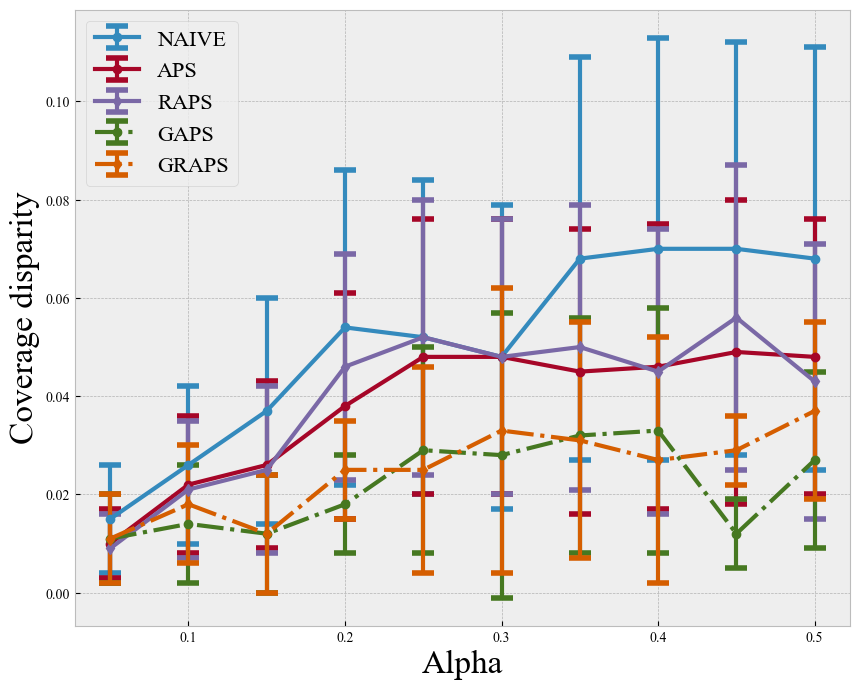

In [50]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Coverage disparity', fontsize=24)

plt.errorbar(
    coverage_disparity.keys(),
    [x['naive'][0] for x in coverage_disparity.values()],
    yerr=[x['naive'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['aps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['raps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['gaps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['graps'][0] for x in coverage_disparity.values()],
    yerr=[x['gaps'][1] for x in coverage_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-coverage-disparity.png')
plt.show()

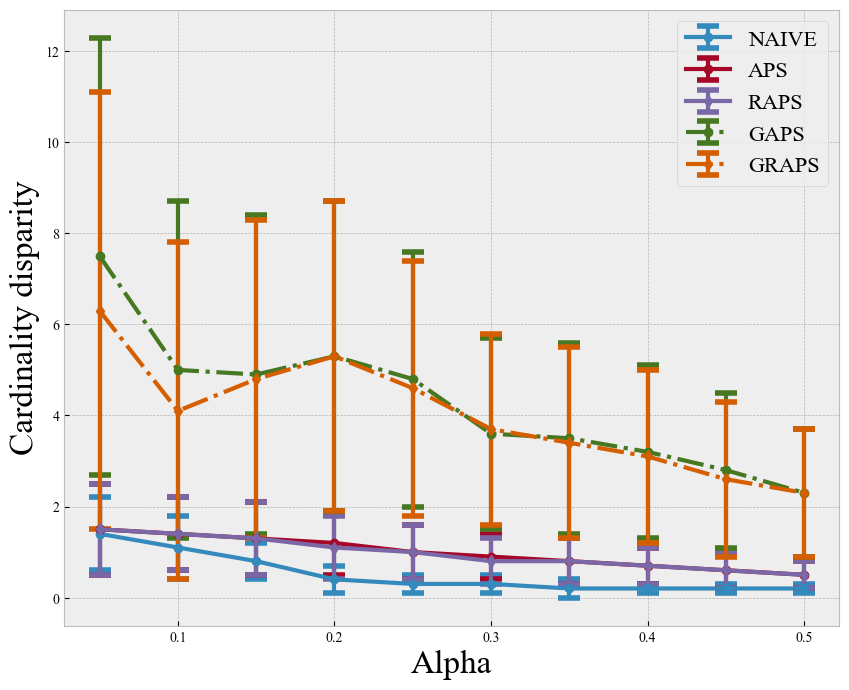

In [51]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Cardinality disparity', fontsize=24)

plt.errorbar(
    cardinality_disparity.keys(),
    [x['naive'][0] for x in cardinality_disparity.values()],
    yerr=[x['naive'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['aps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['raps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='d',
    lw=3,
    capsize=8,
    capthick=4,
    label='RAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['gaps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='o',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GAPS',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['graps'][0] for x in cardinality_disparity.values()],
    yerr=[x['gaps'][1] for x in cardinality_disparity.values()],
    marker='d',
    ls='-.',
    lw=3,
    capsize=8,
    capthick=4,
    label='GRAPS',
)
plt.legend(fontsize=16)
plt.savefig(fig_dir / 'fitz-cardinality-disparity.png')
plt.show()

## References

[1] Groh, Matthew, et al. "Evaluating deep neural networks trained on clinical images in dermatology with the fitzpatrick 17k dataset." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

[2] Lu, Charles, et al. "Fair conformal predictors for applications in medical imaging." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 36. No. 11. 2022.

[3] Messoudi, Soundouss et al. “Deep Conformal Prediction for Robust Models.” Information Processing and Management of Uncertainty in Knowledge-Based Systems: 18th International Conference, IPMU 2020, Lisbon, Portugal, June 15–19, 2020, Proceedings, Part I vol. 1237 528–540. 18 May. 2020, doi:10.1007/978-3-030-50146-4_39
